In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, TimeDistributed, RepeatVector

#### Get historical price for the stock data

In [2]:
def extract_historic_data(ticker, period='max'):
    t = yf.Ticker(ticker)
    history = t.history(period=period)
    return history.Close

In [3]:
AAPL_df = extract_historic_data('AAPL')
AAPL_df.head()

Date
1980-12-12 00:00:00-05:00    0.099192
1980-12-15 00:00:00-05:00    0.094017
1980-12-16 00:00:00-05:00    0.087117
1980-12-17 00:00:00-05:00    0.089273
1980-12-18 00:00:00-05:00    0.091861
Name: Close, dtype: float64

In [4]:
AAPL_df.tail()

Date
2024-03-22 00:00:00-04:00    172.279999
2024-03-25 00:00:00-04:00    170.850006
2024-03-26 00:00:00-04:00    169.710007
2024-03-27 00:00:00-04:00    173.309998
2024-03-28 00:00:00-04:00    171.479996
Name: Close, dtype: float64

#### Break stock data into weekly buckets and get train and test sets

In [11]:
def window_and_reshape(data, timestep):
    NUM_FEATURES = 1
    samples = int(data.shape[0] / timestep)
    result = np.array(np.array_split(data, samples))
    return result.reshape((samples, timestep, NUM_FEATURES))

def transform(train, test, timestep=5):
    train_remainder = train.shape[0] % timestep
    test_remainder = test.shape[0] % timestep
    if train_remainder != 0 and test_remainder != 0:
        train = train[train_remainder : ]
        test = test[test_remainder : ]
    elif train_remainder != 0:
        train = train[train_remainder : ]
    elif test_remainder != 0:
        test = test[test_remainder : ]
    return window_and_reshape(train, timestep), window_and_reshape(test, timestep)

def split_data(data, date_seperator='2023-12-30'):
    train = data[data.index <= date_seperator]
    test = data[data.index > date_seperator]
    return train, test

def etl(ticker):
    data = extract_historic_data(ticker)
    train, test = split_data(data)
    return transform(train, test)

In [12]:
train_data, test_data = etl('AAPL')

In [14]:
print('train_data shape:  ', train_data.shape, '\n', 'test_data shape:  ', test_data.shape )

train_data shape:   (2170, 5, 1) 
 test_data shape:   (12, 5, 1)


#### Breaking data into features and labels

In [24]:
def to_supervised(train, n_input=5, n_out=5):
    """
    Converts our time series prediction problem to a
    supervised learning problem.
    """
    # flatted the data
    data =  train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = [], []
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
            # move along one time step
            in_start += 1
    return np.array(X), np.array(y)

In [25]:
X_train, y_train = to_supervised(train_data)

In [26]:
print('X train Shape: ', X_train.shape, '\n', 'y train Shape: ', y_train.shape)

X train Shape:  (10841, 5, 1) 
 y train Shape:  (10841, 5)


#### Model

In [29]:
def build_model(train, n_input=5):
    """
    Compiles and fits an LSTM model.
    """
    # prepare the data
    X_train, y_train = to_supervised(train)
    # define params
    VERBOSE, NUM_EPOCHS, BATCH_SIZE = 0, 3, 30 # if you want to see it train, set VERBOSE=1
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1] 
    # define model
    model = Sequential() 
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    # compile the model
    print('compiling model....')
    model.compile(optimizer='adam', loss='mse')
    print("fitting model....")
    # fit the model
    model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE)
    print('model is fit....')
    return model

In [30]:
model = build_model(train_data)

compiling model....
fitting model....

model is fit....


#### Prediction and Evaluation

In [33]:
def forecast(model, history, n_input=5):
    """
    Given last weeks actual data, forecasts next weeks prices.
    """
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

def get_predictions(train, test, model, n_input) -> np.array:
    """
    compiles models predictions week by week over entire
    test set.
    """
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = []
    for i in range(len(test)):
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    return np.array(predictions)

In [34]:
pred = get_predictions(train_data, test_data, model, 5)

In [35]:
pred

array([[192.16214, 195.25638, 195.5391 , 196.14064, 196.3186 ],
       [182.76419, 185.65623, 185.97781, 186.53293, 186.7182 ],
       [183.85667, 186.72646, 187.11272, 187.69252, 187.77357],
       [191.78973, 194.8076 , 195.01366, 195.62944, 195.8824 ],
       [189.0838 , 192.10715, 192.55579, 193.15384, 193.16142],
       [186.91423, 189.85696, 190.14717, 190.72847, 190.92444],
       [185.85669, 188.79181, 189.14732, 189.7319 , 189.82529],
       [182.16238, 185.01909, 185.3484 , 185.90106, 186.05418],
       [181.0795 , 183.87636, 184.26604, 184.83603, 184.93094],
       [171.85178, 174.49678, 175.07106, 175.58197, 175.5315 ],
       [171.5954 , 174.13396, 174.50705, 175.0532 , 175.15631],
       [174.20169, 176.82549, 177.2454 , 177.82945, 177.91504]],
      dtype=float32)

#### Plotting the results:

In [36]:
def plot_results(test, preds, df, ylabel='AAPL stock Price') -> None:
  """
  Plots training data in blue, actual values in red, and predictions in green,
  over time.
  """
  fig, ax = plt.subplots(figsize=(20,6))
  plot_test = test[1:]
  plot_preds = preds[1:]
  x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index # df can be the pd.Series of closing prices
  plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  ax.plot(x, plot_test, label='actual')
  ax.plot(x, plot_preds, label='preds')
  ax.set_xlabel('Date')
  ax.set_ylabel(ylabel)
  ax.legend()
  plt.show()

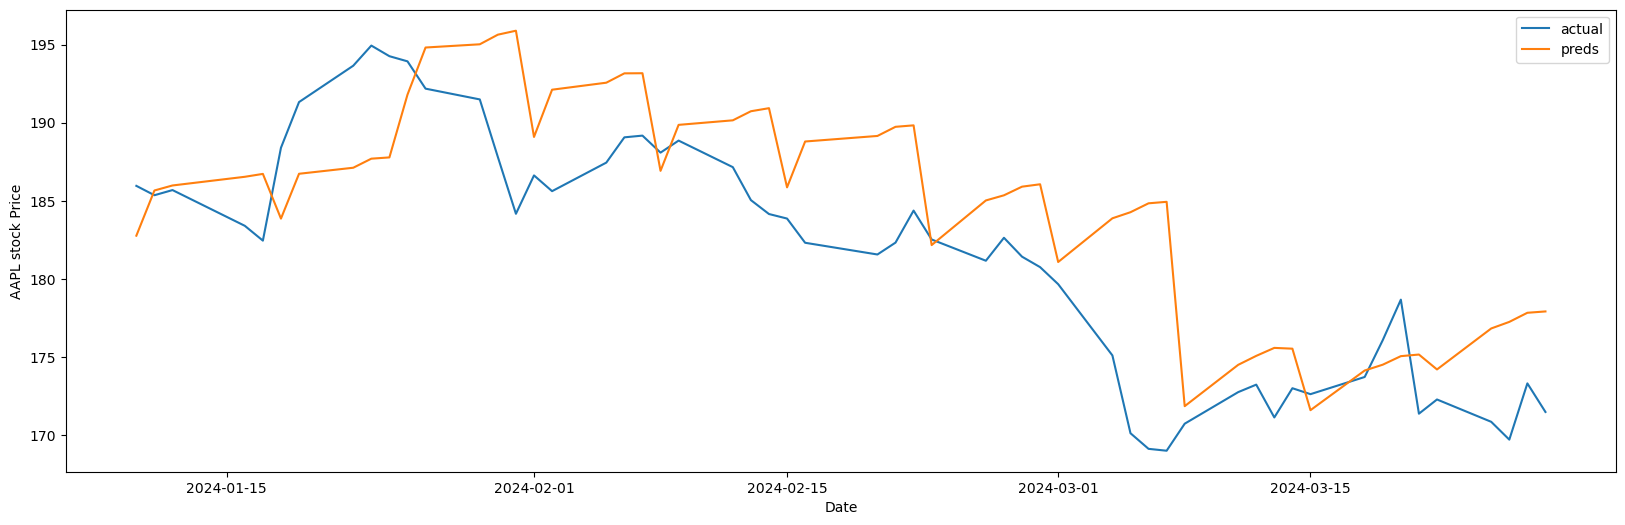

In [37]:
plot_results(test_data, pred, AAPL_df)

#### CNN_LSTM model

In [40]:
def build_cnn_lstm(train, n_input=5):
  """
  Builds and trains our CNN-LSTM model. 
  """
  # prepare the data
  X_train, y_train = to_supervised(train, n_input, n_input)
  # define params
  VERBOSE, NUM_EPOCHS, BATCH_SIZE = 0, 20, 16
  n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1] 
  y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
  # define model
  model = Sequential()
  # input layer: this is taking our raw data and convoluting it, essentially its picking up salient features.
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features), padding='same')) 
  # this is our first hidden layer, its taking in the ouput of our input layer and finding subtle patterns in our features
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))  
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(RepeatVector(n_outputs))
  # time series magic occurs
  model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
  model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
  model.add(TimeDistributed(Dense(100, activation='relu'))) # gonna change this from relu to softmax
  model.add(TimeDistributed(Dense(1)))
  # compile the model
  print('compiling model....')
  model.compile(optimizer='adam', loss='mse') 
  print("fitting model....")
  # fit the model
  model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE)
  print('model is fit....')
  return model

In [41]:
cnn_lstm_model = build_cnn_lstm(train_data)

compiling model....
fitting model....
model is fit....


In [44]:
cnn_lstm_pred = get_predictions(train_data, test_data, cnn_lstm_model, 5)

In [45]:
cnn_lstm_pred

array([[[197.91882],
        [196.96765],
        [196.97037],
        [196.8963 ],
        [197.16011]],

       [[190.18031],
        [189.29044],
        [189.26816],
        [189.18428],
        [189.41353]],

       [[187.8808 ],
        [186.96465],
        [186.98721],
        [186.92274],
        [187.19383]],

       [[198.85847],
        [197.89001],
        [197.89124],
        [197.81004],
        [198.07335]],

       [[191.2337 ],
        [190.31291],
        [190.34802],
        [190.29997],
        [190.58562]],

       [[193.75272],
        [192.81708],
        [192.81035],
        [192.72844],
        [192.97865]],

       [[190.01642],
        [189.09457],
        [189.11484],
        [189.04893],
        [189.32004]],

       [[188.76448],
        [187.85051],
        [187.8438 ],
        [187.75784],
        [188.00351]],

       [[185.73384],
        [184.8297 ],
        [184.8441 ],
        [184.77602],
        [185.03664]],

       [[175.2669 ],
        [174.437

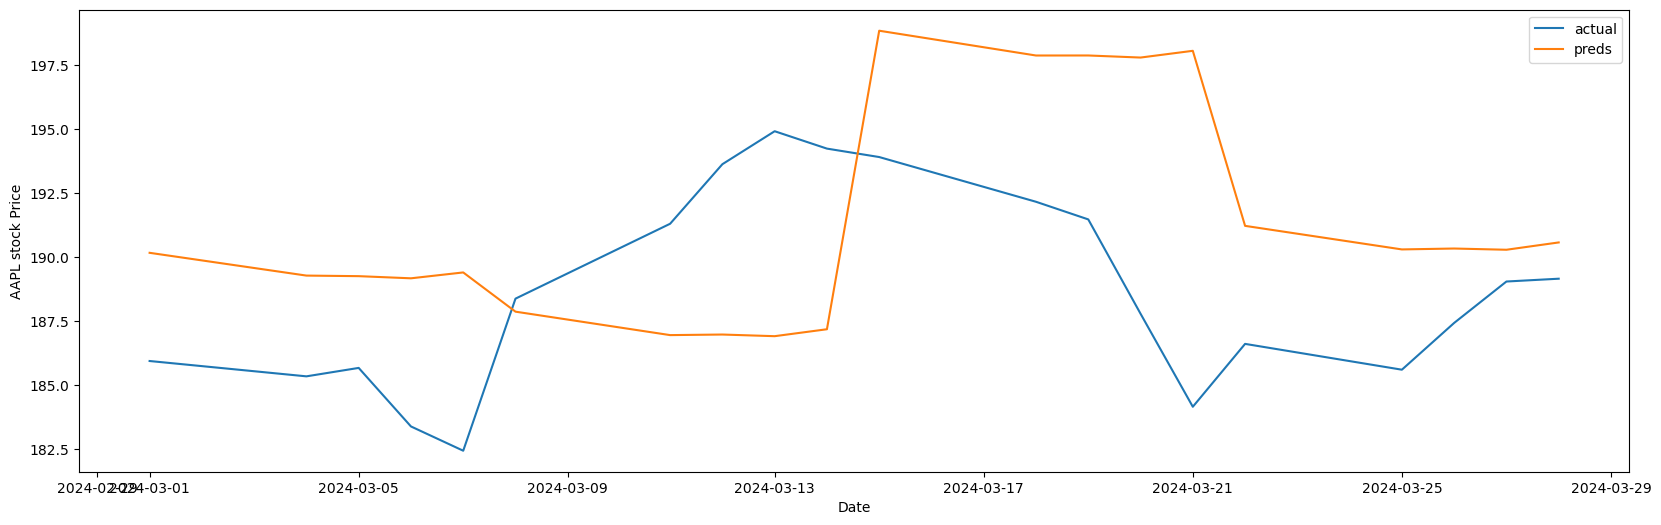

In [48]:
plot_results(test_data[0:5,::], cnn_lstm_pred[0:5,: :], AAPL_df)

#### LSTM model

In [51]:
X_test, y_test = to_supervised(test_data)

In [52]:
def build_lstm(X_train, y_train, X_test, y_test, epochs=25, batch_size=32):
  """
  Builds, compiles, and fits our LSTM baseline model.
  """
  n_timesteps, n_features, n_outputs = 5, 1, 5 
  callbacks = [tf.keras.callbacks.EarlyStopping(patience=10,
                                                restore_best_weights=True)]
  model = Sequential()
  model.add(LSTM(200, activation='relu', 
                 input_shape=(n_timesteps, n_features)))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(n_outputs))
  print('compiling baseline model...')
  model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
  print('fitting model...')
  history = model.fit(X_train, y_train,
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_data=(X_test, y_test),
                      verbose=1, 
                      callbacks=callbacks)
  return model, history

In [54]:
lstm_model, history = build_lstm(X_train, y_train, X_test, y_test)

compiling baseline model...
fitting model...
Epoch 1/25
339/339 [==============================] - 3s 6ms/step - loss: 93.2699 - mae: 1.7297 - mape: 21.8592 - val_loss: 27.8936 - val_mae: 4.1401 - val_mape: 2.2715
Epoch 2/25
339/339 [==============================] - 2s 5ms/step - loss: 4.3181 - mae: 0.7336 - mape: 13.6803 - val_loss: 42.6484 - val_mae: 5.0845 - val_mape: 2.8252
Epoch 3/25
339/339 [==============================] - 2s 5ms/step - loss: 3.9893 - mae: 0.6921 - mape: 10.2343 - val_loss: 27.3705 - val_mae: 4.1001 - val_mape: 2.2502
Epoch 4/25
339/339 [==============================] - 2s 5ms/step - loss: 4.3436 - mae: 0.7380 - mape: 12.2556 - val_loss: 26.1862 - val_mae: 4.0061 - val_mape: 2.2111
Epoch 5/25
339/339 [==============================] - 2s 5ms/step - loss: 3.9166 - mae: 0.6881 - mape: 9.4077 - val_loss: 88.4169 - val_mae: 7.9383 - val_mape: 4.3287
Epoch 6/25
339/339 [==============================] - 2s 5ms/step - loss: 4.3948 - mae: 0.7318 - mape: 10.2038 - va

In [55]:
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 200)               161600    
                                                                 
 dense_10 (Dense)            (None, 50)                10050     
                                                                 
 dense_11 (Dense)            (None, 5)                 255       
                                                                 
Total params: 171905 (671.50 KB)
Trainable params: 171905 (671.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
lstm_pred = get_predictions(train_data, test_data, lstm_model, 5)

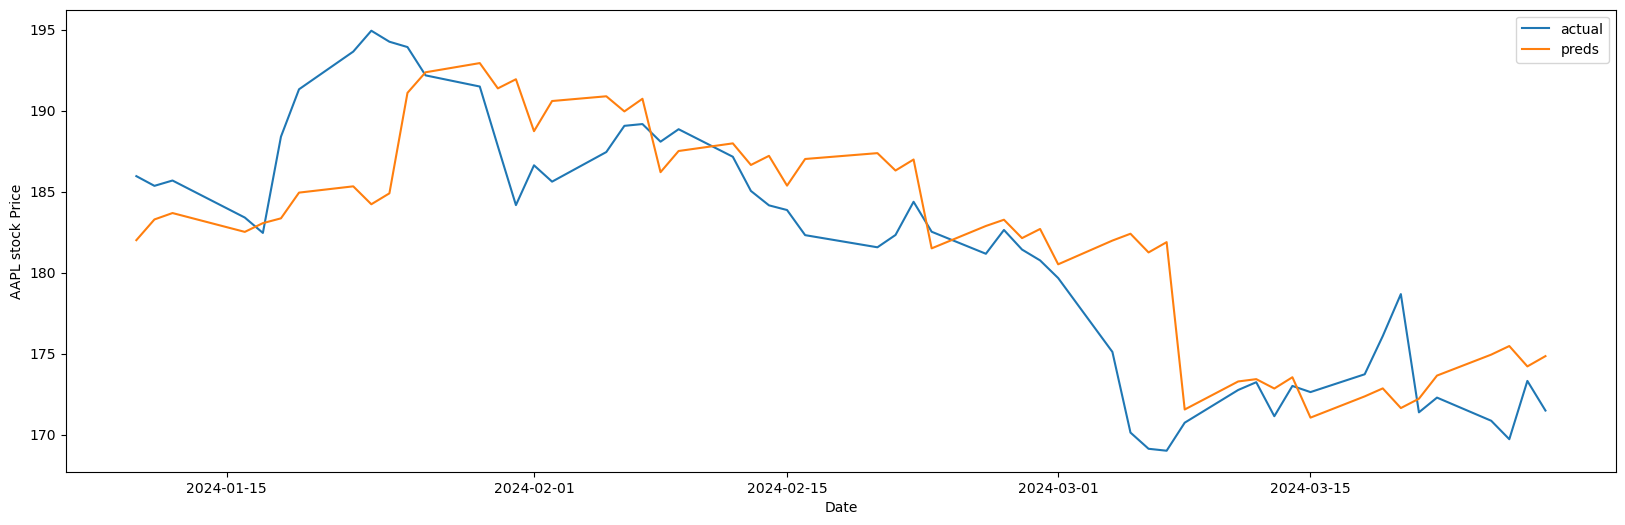

In [60]:
plot_results(test_data, lstm_pred, AAPL_df)